In [1]:
%run SAT_help_functions.ipynb
%matplotlib inline

In [2]:
data_dir = '/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Dutilh2019/validation_text_data/exp_4/pp'
sample_size = 20
correct = 'correct'
corrects = [True, False]
cond = 'cond' 
conds = ['A', 'B']
rt = 'rt'

model = 'DDM2v2a2ter'
dataset = 'Dutilh2019'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)

In [3]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)

    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]

#get_RT_quantile_sub(df = df, rt = rt, correct = correct, corrects = corrects, cond = cond, conds = conds)

In [4]:
def get_RT_quantile(data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    #xxs = []
    #xxa = []
    for i in range(sample_size):
        path = os.path.join(data_dir+str(i+1)+".txt")
        df = pd.read_csv(path, sep = " ")
        #print(df)
        df = df[df["rt"]<5]

        #print(df.loc[df['cond']=='A']['correct'].mean())
        #print(df.loc[df['cond']=='B']['correct'].mean())
        #xxs.append(df.loc[df['cond']=='A']['correct'].mean())
        #xxa.append(df.loc[df['cond']=='B']['correct'].mean())

        #print(df.loc[df['cond']=='A']['rt'].mean())
        #print(df.loc[df['cond']=='B']['rt'].mean())
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num

    #print(nums)
    
    #return xxs, xxa
    return RT_cor_ss.mean(axis = 0), RT_cor_as.mean(axis = 0), RT_err_ss.mean(axis = 0), RT_err_as.mean(axis = 0), nums.mean(axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

#xxs, xxa = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

In [5]:
#params = np.array(params_all)[0,1:6]

class DriftBothSpeedAcc(Drift):
    name = "DriftBothSpeedAcc"
    required_parameters = ["Vspeed","Vacc", "Kspeed", "Kacc"]
    required_conditions = ['cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['cond'] == 'A':
            return self.Vspeed + x*self.Kspeed 
        elif conditions['cond'] == 'B':
            return self.Vacc + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")
            
class DriftConstantSpeedAcc(Drift):
    name = "DriftConstantSpeedAcc"
    required_parameters = ["Vspeed","Vacc"]
    required_conditions = ['cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['cond'] == 'A':
            return self.Vspeed
        elif conditions['cond'] == 'B':
            return self.Vacc
        else: 
            print("Non-implemented SAT conditions")

class DriftExcitationSpeedAcc(Drift):
    name = "DriftSpeedAcc"
    required_parameters = ["drift", "Kspeed", "Kacc"]
    required_conditions = ['cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['cond'] == 'A':
            return self.drift + x*self.Kspeed 
        elif conditions['cond'] == 'B':
            return self.drift + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")

class BoundSpeedAcc(Bound):
    name = "BoundSpeedAcc"
    required_parameters = ["Bspeed", "Bacc"]
    required_conditions = ['cond']
    def get_bound(self, conditions, *args, **kwargs):
        assert self.Bacc > 0
        assert self.Bspeed > 0
        if conditions['cond'] == 'A':
            return self.Bspeed
        elif conditions['cond'] == 'B':
            return self.Bacc
        else:
            print("Non-implemented SAT conditions")
            
class NondecisionSpeedAcc(OverlayNonDecision):
    name = "NondecisionSpeedAcc"
    required_parameters = ["tSpeed", 'tAcc']
    required_conditions = ['cond']
        
    def get_nondecision_time(self, conditions, **kwargs):
        if conditions['cond'] == 'A':
            return self.tSpeed 
        elif conditions['cond'] == 'B':
            return self.tAcc
        else: 
            print("Non-implemented SAT conditions")
            
def get_RT_quantile_DDM_sub(params, T_dur=5):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'cond':'A'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'cond':'B'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'cond', ['A', 'B'], 'RT')
#get_RT_quantile_DDM_sub(params = np.array(params_all)[3,1:6])

In [6]:
#np.array(params_all)[3,1:6]

In [7]:
def get_RT_quantile_DDM(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        params = np.array(params_all)[i,1:7]
        
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

<Axes: xlabel='Probability of Response', ylabel='RT'>

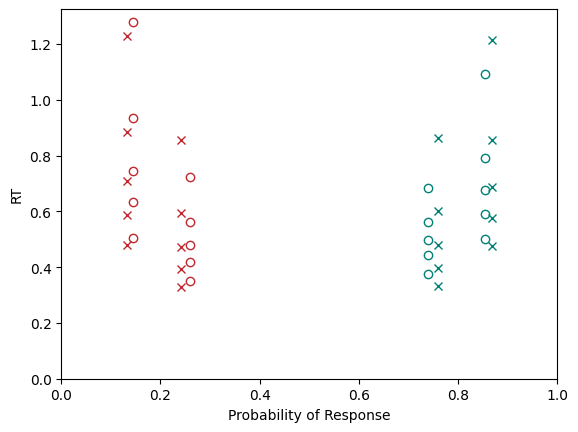

In [8]:
def DDM_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')
    #print(nums[0]/(nums[0]+nums[2]))
    #print(nums[1]/(nums[1]+nums[3]))
    #print(nums)
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
DDM_QP_plot()

In [9]:
model = 'OUM2v2k2ter'
dataset = 'Dutilh2019'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)

In [10]:
#params = np.array(params_all)[0,1:8]

In [11]:
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'cond':'A'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'cond':'B'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], cond, conds, 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

In [12]:
def get_RT_quantile_OUM2v2k2ter(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):

        params = np.array(params_all)[i,1:8]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

<Axes: xlabel='Probability of Response', ylabel='RT'>

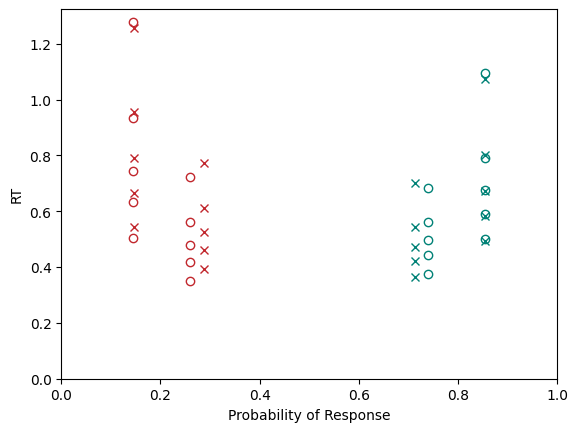

In [13]:
def OUM2v2k2ter_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
OUM2v2k2ter_QP_plot()

<Axes: xlabel='Probability of Response', ylabel='RT'>

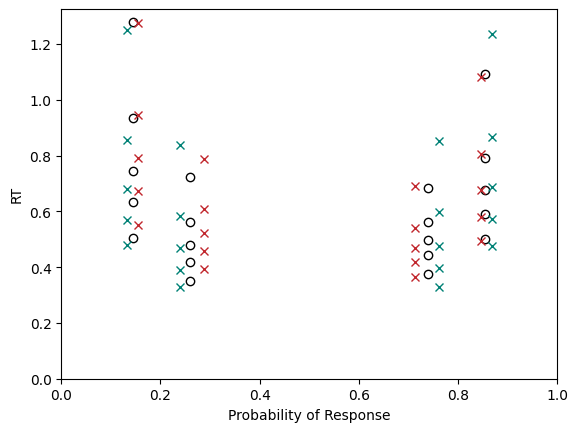

In [14]:
DDM_OUM_QP_plot(dataset, data_dir = data_dir,sample_size= sample_size, 
                   correct = correct, corrects = corrects,
                   cond = cond, conds = conds, rt = rt)